In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import time
import cv2
import os

In [2]:
class Data(Dataset):
    def __init__(self, file_namex, file_namey):
        self.x = np.load(file_namex)
        self.y = np.load(file_namey)
        self.height, self.width = self.x[0].shape[:-1]
    def __len__(self):
        return len(self.x)
    def get(self, c, index):
        s = np.where(self.y == c)[0]
        return s[index%len(s)]
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
        x = torch.from_numpy(self.x[index])
        y = torch.from_numpy(np.array(self.y[index]))
        return {'image':x,'label':y}
trainset = Data(r'Data/Train_set_x_sequence.npy', r'Data/Train_set_y_sequence.npy')
valset = Data(r'Data/Val_set_x_sequence.npy', r'Data/Val_set_y_sequence.npy')

Length of Training set   :  7050
Length of Validation set :  1857
For training  :  torch.Size([3, 40, 140]) torch.Size([])
For validation:  torch.Size([3, 40, 140]) torch.Size([])
Label :  0


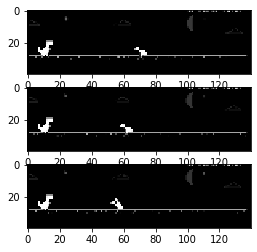

In [3]:
index= 20
print("Length of Training set   : ",len(trainset))
print("Length of Validation set : ",len(valset))
sample = trainset[index]

print('For training  : ',sample['image'].shape, sample['label'].shape)
print('For validation: ',valset[index]['image'].shape, valset[index]['label'].shape)
plt.subplot(3,1,1)
plt.imshow(sample['image'][0], cmap='gray')
plt.subplot(3,1,2)
plt.imshow(sample['image'][1], cmap='gray')
plt.subplot(3,1,3)
plt.imshow(sample['image'][2], cmap='gray')
print('Label : ', int(sample['label']))

In [4]:
class Net1(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1_1 = nn.Conv2d(1, 64, 3)
        self.batch1_1 = nn.BatchNorm2d(64)
        self.relu1_1 = nn.ReLU()
        self.conv1_2 = nn.Conv2d(64, 128, 3)
        self.batch1_2 = nn.BatchNorm2d(128)
        self.relu1_2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(3, stride=2)
        
        self.dropout1 = nn.Dropout(0.25)
        
        self.conv2_1 = nn.Conv2d(128, 256, 3)
        self.batch2_1 = nn.BatchNorm2d(256)
        self.relu2_1 = nn.ReLU()
        self.conv2_2 = nn.Conv2d(256, 256, 3)
        self.batch2_2 = nn.BatchNorm2d(256)
        self.relu2_2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(3, stride=2)

        self.dropout2 = nn.Dropout(0.25)
        
        self.fc1 = nn.Linear(256*6*31, 512)
        self.batch_fc1 = nn.BatchNorm1d(512)
        self.relu_fc1 = nn.ReLU()
        
        self.fc2 = nn.Linear(512, 126)
        self.batch_fc2 = nn.BatchNorm1d(126)
        self.relu_fc2 = nn.ReLU()
        
        #self.fc3 = nn.Linear(256, 126)
        #self.batch_fc3 = nn.BatchNorm1d(126)
        #self.relu_fc3 = nn.ReLU()
        
        self.fc4 = nn.Linear(126, 3)
        
    def forward(self, x, choice=0):
        x = x/255
        x = self.relu1_1(self.batch1_1(self.conv1_1(x)))
        x = self.relu1_2(self.batch1_2(self.conv1_2(x)))
        x = self.pool1(x)
        
        x = self.dropout1(x)
        
        x = self.relu2_1(self.batch2_1(self.conv2_1(x)))
        x = self.relu2_2(self.batch2_2(self.conv2_2(x)))
        x = self.pool2(x)
        
        x = self.dropout2(x)
        
        #print(x.shape)
        
        x = x.view(-1, 256*6*31)
        
        x = self.relu_fc1(self.batch_fc1(self.fc1(x)))
        
        x = self.relu_fc2(self.batch_fc2(self.fc2(x)))
        
        #x = self.relu_fc3(self.batch_fc3(self.fc3(x)))
        
        x = self.fc4(x)
        
        return x

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.batch1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, stride =2)
        
        self.dropout1 = nn.Dropout(0.2) 
        
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.batch2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, stride=2)
        
        self.dropout2 = nn.Dropout(0.25) 
        
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.batch3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, stride=2)
        
        self.dropout3 = nn.Dropout(0.25) 
        
        
        self.fc1 = nn.Linear(64*3*15, 126)
        self.batch_fc1 = nn.BatchNorm1d(126)
        self.relu_fc1 = nn.ReLU()
        
        self.dropout4 = nn.Dropout(0.25) 
        
        self.fc2 = nn.Linear(126, 30)
        self.batch_fc2 = nn.BatchNorm1d(30)
        self.relu_fc2 = nn.ReLU()
        
        self.fc3 = nn.Linear(30, 3)
        
    def forward(self, x, choice=0):
        x = x/255
        x = self.relu1(self.batch1(self.conv1(x)))
        x = self.pool1(x)
        
        x = self.dropout1(x)
        
        x = self.relu2(self.batch2(self.conv2(x)))
        x = self.pool2(x)
        
        x = self.dropout2(x)
        
        #print("After 2: " ,x.shape)
        
        x = self.relu3(self.batch3(self.conv3(x)))
        x = self.pool3(x)
        x = self.dropout3(x)
        
        #print(x.shape)
        
        x = x.view(-1, 64*3*15)
        
        x = self.relu_fc1(self.batch_fc1(self.fc1(x)))
        
        x = self.dropout4(x)
        
        x = self.relu_fc2(self.batch_fc2(self.fc2(x)))
        
        x = self.fc3(x)
        
        return x

In [15]:
model = Net().cuda()
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (batch1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.2, inplace=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (batch3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=2880, out_features=126, bias=True)
  (batch_fc1): BatchNorm1d(1

In [16]:
#model.dropout1 = nn.Dropout(0.1)
#model.dropout2 = nn.Dropout(0.1)

trainloader = DataLoader(trainset, batch_size=40, shuffle = True)
valloader = DataLoader(valset, batch_size = 80)
cost = nn.CrossEntropyLoss(weight = torch.Tensor([1,1,10]).cuda())
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
epoch = 20

t = time.time()

print("Starting Training....")
for ep in range(epoch):
    model.train()
    size = 0
    cost_loss = 0
    for i_batch, sample in enumerate(trainloader):
        x = sample['image'].float().cuda()
        y = sample['label'].long().cuda()
        optimizer.zero_grad()
        output = model(x)
        loss = cost(output, y)
        loss.backward()
        optimizer.step()
        size +=1
        cost_loss += loss.item()
        if i_batch%20 == 19:
            print("[ Epoch: %3d  Mini-Batch: %3d ] Loss: %.3f"%(ep+1, i_batch+1, cost_loss/size), end='\r')
            size = 0
            cost_loss = 0
    model.eval()
    val_loss = 0.0
    val_accurate = 0
    train_loss = 0.0
    train_accurate = 0
    with torch.no_grad():
        for train_batch, sample in enumerate(trainloader):
            x = sample['image'].float().cuda()
            y = sample['label'].long().cuda()
            output = model(x)
            loss = cost(output, y)
            output = torch.argmax(output, 1)
            train_accurate += torch.sum(output==y)
            train_loss += loss.item()
        for val_batch, sample in enumerate(valloader):
            x = sample['image'].float().cuda()
            y = sample['label'].long().cuda()
            output = model(x)
            loss = cost(output, y)
            output = torch.argmax(output, 1)
            val_accurate += torch.sum(output==y)
            val_loss += loss.item()
    print("[   Epoch: %3d   ]  Train Loss:  %.3f  Train Acc: %.2f %%     Val Loss:  %.3f  Val Acc:  %.2f %%"
          %(ep+1, train_loss/(train_batch+1), 100.0*train_accurate/len(trainset), val_loss/(val_batch+1), 100.0*val_accurate/len(valset)))
            
print("Training complete!!!...")
print("Time taken to train : %.2f min"%((time.time()-t)/60))

Starting Training....
[   Epoch:   1   ]  Train Loss:  0.109  Train Acc: 89.21 %     Val Loss:  0.349  Val Acc:  88.48 %
[   Epoch:   2   ]  Train Loss:  0.080  Train Acc: 90.30 %     Val Loss:  0.266  Val Acc:  89.93 %
[   Epoch:   3   ]  Train Loss:  0.077  Train Acc: 91.21 %     Val Loss:  0.220  Val Acc:  91.38 %
[   Epoch:   4   ]  Train Loss:  0.069  Train Acc: 91.15 %     Val Loss:  0.235  Val Acc:  90.95 %
[   Epoch:   5   ]  Train Loss:  0.075  Train Acc: 90.14 %     Val Loss:  0.281  Val Acc:  89.82 %
[   Epoch:   6   ]  Train Loss:  0.060  Train Acc: 92.04 %     Val Loss:  0.218  Val Acc:  91.98 %
[   Epoch:   7   ]  Train Loss:  0.061  Train Acc: 91.70 %     Val Loss:  0.228  Val Acc:  91.22 %
[   Epoch:   8   ]  Train Loss:  0.057  Train Acc: 92.52 %     Val Loss:  0.186  Val Acc:  93.16 %
[   Epoch:   9   ]  Train Loss:  0.061  Train Acc: 92.50 %     Val Loss:  0.182  Val Acc:  93.11 %
[   Epoch:  10   ]  Train Loss:  0.057  Train Acc: 92.60 %     Val Loss:  0.193  Val Ac

In [17]:
train_data = DataLoader(trainset, batch_size=120, shuffle=True)
val_data = DataLoader(valset, batch_size=120, shuffle=True)
size = 0
cost = 0.0
model.eval()
with torch.no_grad():
    for i, sample in enumerate(train_data):
        x = sample['image'].float().cuda()
        y = sample['label'].long()
        output = model(x)
        output = torch.argmax(output, 1).cpu()
        cost += torch.sum(output == y).float()/len(output)
        size += 1
    cost = cost/size
    train_acc = 100.0*cost.item()
    print("Train Accuracy: %.2f %%"%(train_acc))
    size = 0
    cost = 0.0
    for i, sample in enumerate(val_data):
        x = sample['image'].float().cuda()
        y = sample['label'].long()
        output = model(x)
        output = torch.argmax(output, 1).cpu()
        cost += torch.sum(output == y).float()/len(output)
        size += 1
    cost = cost/size
    test_acc = 100.0*cost.item()
    print("Val Accuracy: %.2f %%"%(test_acc))

Train Accuracy: 94.14 %
Val Accuracy: 92.84 %


In [20]:
import winsound

winsound.Beep(400, 1000)

In [18]:
output

tensor([0, 1, 0, 2, 2, 2, 2, 2, 2, 2, 0, 1, 2, 1, 1, 2, 0, 2, 2, 2, 2, 1, 2, 1,
        2, 0, 0, 0, 2, 1, 2, 0, 1, 2, 1, 1, 1, 2, 1, 0, 0, 1, 1, 2, 1, 0, 2, 0,
        0, 1, 0, 1, 1, 1, 0, 1, 0])

In [19]:
y

tensor([0, 1, 0, 2, 2, 2, 2, 2, 2, 2, 0, 1, 2, 1, 1, 1, 0, 2, 2, 2, 1, 1, 2, 1,
        2, 0, 0, 0, 2, 1, 2, 0, 1, 2, 1, 1, 1, 2, 1, 0, 1, 1, 1, 2, 1, 0, 2, 0,
        0, 1, 0, 0, 1, 1, 1, 1, 0])

### Write Model

In [20]:
name = 'Model_v11'

path = os.path.join('Models', name)

os.mkdir(path)

torch.save(model.state_dict(), os.path.join(path, name))

log = ''

with open(os.path.join(path, 'Remarks.txt'), 'w') as f:
    f.write("\n\n *******************Model Details******************** \n\n")
    
    f.write('Train Accuracy: %d%%\n Test Accuracy: %d%%\n'%(train_acc, test_acc))
    c= ''
    f.write('\n Parameters: \n\n')
    for par in model.state_dict():
        c += str(par)+'\t'+str(model.state_dict()[par].size())+'\n'
        
    f.write(c)
    
    f.write("\nLast Loss: %.4f"%(loss.item()))
    f.write('\n\n'+log)

### Read Model

In [22]:
model = Net().cuda()
model.load_state_dict(torch.load(r'Models\Model_v11\Model_v11'))
model.eval()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (batch1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.2, inplace=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (batch3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=2880, out_features=126, bias=True)
  (batch_fc1): BatchNorm1d(1

In [15]:
len(valloader)

24